# Projeto de Filtro - Parte 1: Análise Inicial do Sinal

## Objetivo
Fazer o espectrograma do sinal bruto com resolução de 10 Hz e identificar as regiões de sinal DTMF e regiões de ruído da 9ª sinfonia de Beethoven.

---

In [6]:
# Importar bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Configuração de plotagem
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Carregar o arquivo de áudio

In [7]:
# Carregar o arquivo de áudio
# Certifique-se de que o arquivo Dados_XX.wav está no mesmo diretório
arquivo = 'dados_B.wav'  # Substitua XX pelo número correto

try:
    fs, sinal = wavfile.read(arquivo)
    print(f"Arquivo carregado com sucesso!")
    print(f"Taxa de amostragem: {fs} Hz")
    print(f"Número de amostras: {len(sinal)}")
    print(f"Duração: {len(sinal)/fs:.2f} segundos")
    print(f"Tipo de dado: {sinal.dtype}")
    
    # Normalizar o sinal se necessário
    if sinal.dtype == np.int16:
        sinal = sinal / 32768.0
    elif sinal.dtype == np.int32:
        sinal = sinal / 2147483648.0
        
except FileNotFoundError:
    print(f"Erro: Arquivo '{arquivo}' não encontrado!")
    print("Por favor, coloque o arquivo no mesmo diretório deste notebook.")

Arquivo carregado com sucesso!
Taxa de amostragem: 24000 Hz
Número de amostras: 216000
Duração: 9.00 segundos
Tipo de dado: int16


## 2. Visualizar o sinal no domínio do tempo

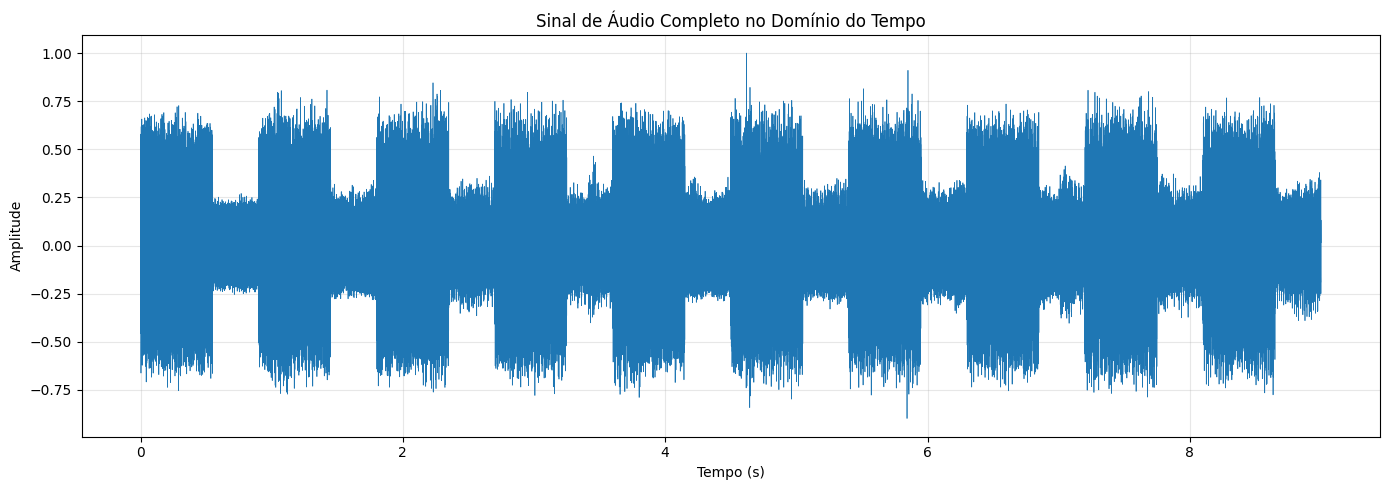


Observações:
- Amplitude máxima: 1.0000
- Amplitude média: 0.1793


In [8]:
# Criar vetor de tempo
tempo = np.arange(len(sinal)) / fs

# Plotar sinal completo
plt.figure(figsize=(14, 5))
plt.plot(tempo, sinal, linewidth=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal de Áudio Completo no Domínio do Tempo')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nObservações:")
print(f"- Amplitude máxima: {np.max(np.abs(sinal)):.4f}")
print(f"- Amplitude média: {np.mean(np.abs(sinal)):.4f}")

## 3. Espectrograma com resolução de 10 Hz

Para obter uma resolução de frequência de 10 Hz, precisamos calcular o tamanho da janela:
- Resolução de frequência: Δf = fs / NFFT
- Para Δf = 10 Hz: NFFT = fs / 10

In [9]:
# Calcular tamanho da FFT para resolução de 10 Hz
resolucao_desejada = 10  # Hz
nfft = int(fs / resolucao_desejada)

# Ajustar para próxima potência de 2 (melhora performance)
nfft_pot2 = int(2**np.ceil(np.log2(nfft)))

print(f"Resolução desejada: {resolucao_desejada} Hz")
print(f"NFFT calculado: {nfft}")
print(f"NFFT (potência de 2): {nfft_pot2}")
print(f"Resolução real: {fs/nfft:.2f} Hz")
print(f"Resolução (pot 2): {fs/nfft_pot2:.2f} Hz")

# Usar o valor que dá resolução mais próxima de 10 Hz
nfft_final = nfft

Resolução desejada: 10 Hz
NFFT calculado: 2400
NFFT (potência de 2): 4096
Resolução real: 10.00 Hz
Resolução (pot 2): 5.86 Hz


In [10]:
# Calcular espectrograma
# Parâmetros:
# - window: janela de Hamming
# - nperseg: tamanho do segmento = NFFT
# - noverlap: sobreposição de 50%
# - nfft: tamanho da FFT

f, t, Sxx = signal.spectrogram(sinal, 
                                fs=fs,
                                window='hamming',
                                nperseg=nfft_final,
                                noverlap=nfft_final//2,
                                nfft=nfft_final,
                                scaling='density')

# Converter para dB
Sxx_dB = 10 * np.log10(Sxx + 1e-12)

print(f"\nEspectrograma calculado:")
print(f"Frequências: {len(f)} pontos (0 a {f[-1]:.1f} Hz)")
print(f"Tempo: {len(t)} segmentos (0 a {t[-1]:.2f} s)")
print(f"Resolução de frequência: {f[1]-f[0]:.2f} Hz")


Espectrograma calculado:
Frequências: 1201 pontos (0 a 12000.0 Hz)
Tempo: 179 segmentos (0 a 8.95 s)
Resolução de frequência: 10.00 Hz


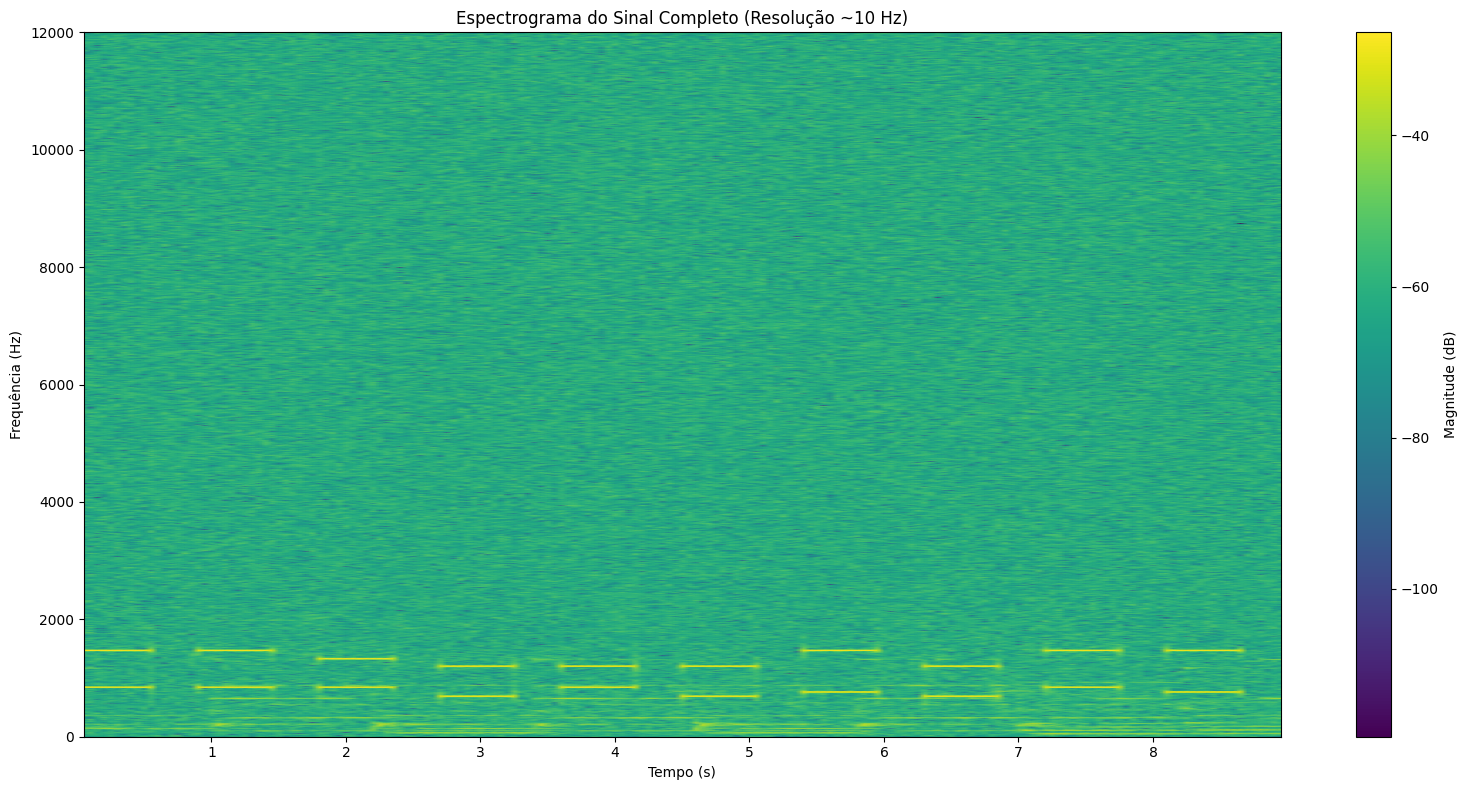

In [11]:
# Plotar espectrograma completo
plt.figure(figsize=(16, 8))
plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma do Sinal Completo (Resolução ~10 Hz)')
plt.colorbar(label='Magnitude (dB)')
plt.ylim([0, fs/2])  # Mostrar até frequência de Nyquist
plt.tight_layout()
plt.show()

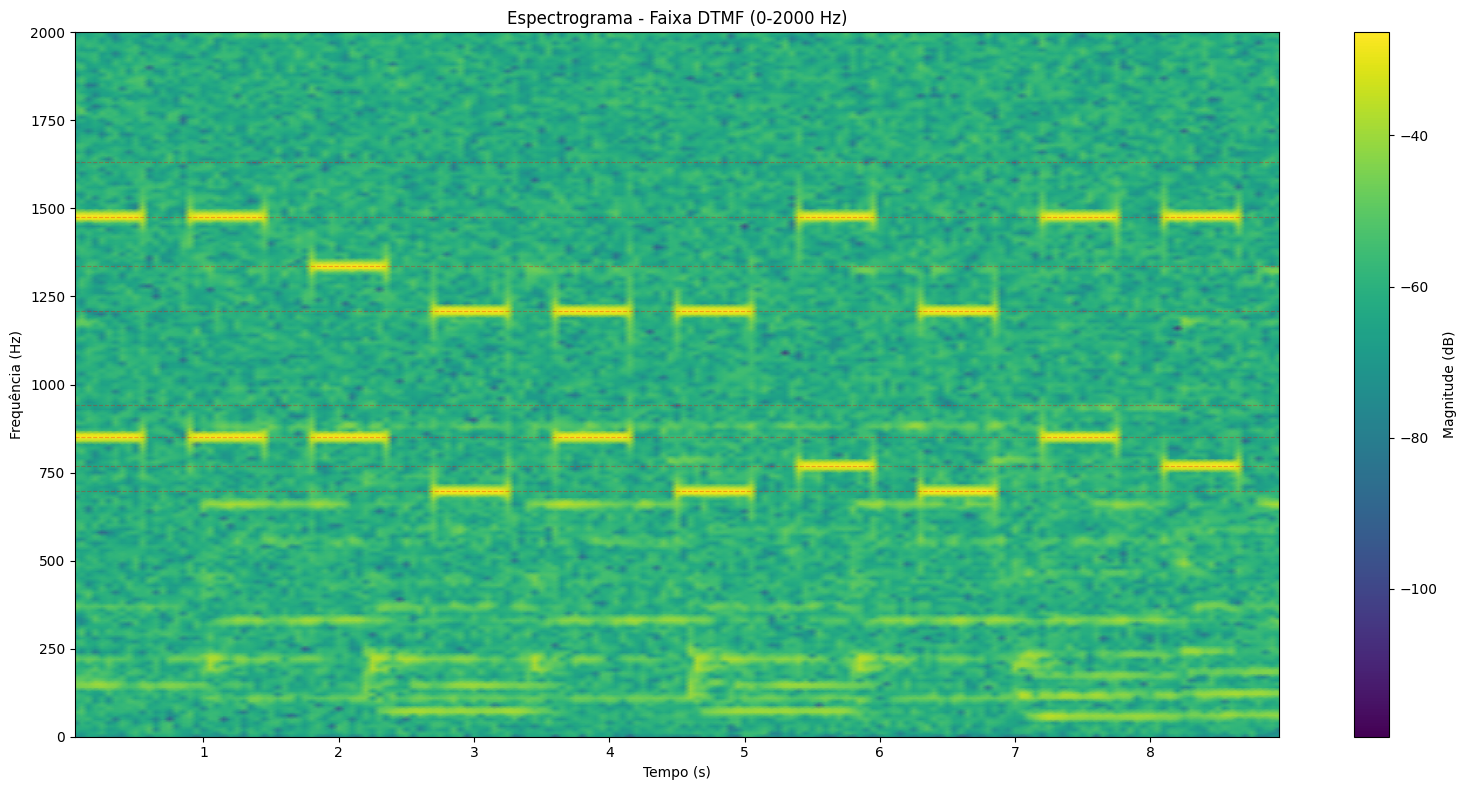


Frequências DTMF de referência:
Baixas: [697, 770, 852, 941]
Altas: [1209, 1336, 1477, 1633]


In [ ]:
# Plotar espectrograma focado na faixa de DTMF (0-2000 Hz)
plt.figure(figsize=(16, 8))
plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='viridis')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Tempo (s)')
plt.title('Espectrograma - Faixa DTMF (0-2000 Hz)')
plt.colorbar(label='Magnitude (dB)')
plt.ylim([0, 2000])  # Faixa típica de DTMF

# Adicionar linhas de referência das frequências DTMF
freq_dtmf_baixas = [697, 770, 852, 941]  # Frequências baixas
freq_dtmf_altas = [1209, 1336, 1477, 1633]  # Frequências altas

for freq in freq_dtmf_baixas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.3, linewidth=0.8)
for freq in freq_dtmf_altas:
    plt.axhline(y=freq, color='r', linestyle='--', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nFrequências DTMF de referência:")
print(f"Baixas: {freq_dtmf_baixas}")
print(f"Altas: {freq_dtmf_altas}")

# Se pa que da pra tirar, talvez seja demais, marcondo aqui pra lembrar

## 4. Análise e Identificação de Regiões

### 4.1 Identificação de regiões DTMF vs Ruído (9ª Sinfonia)

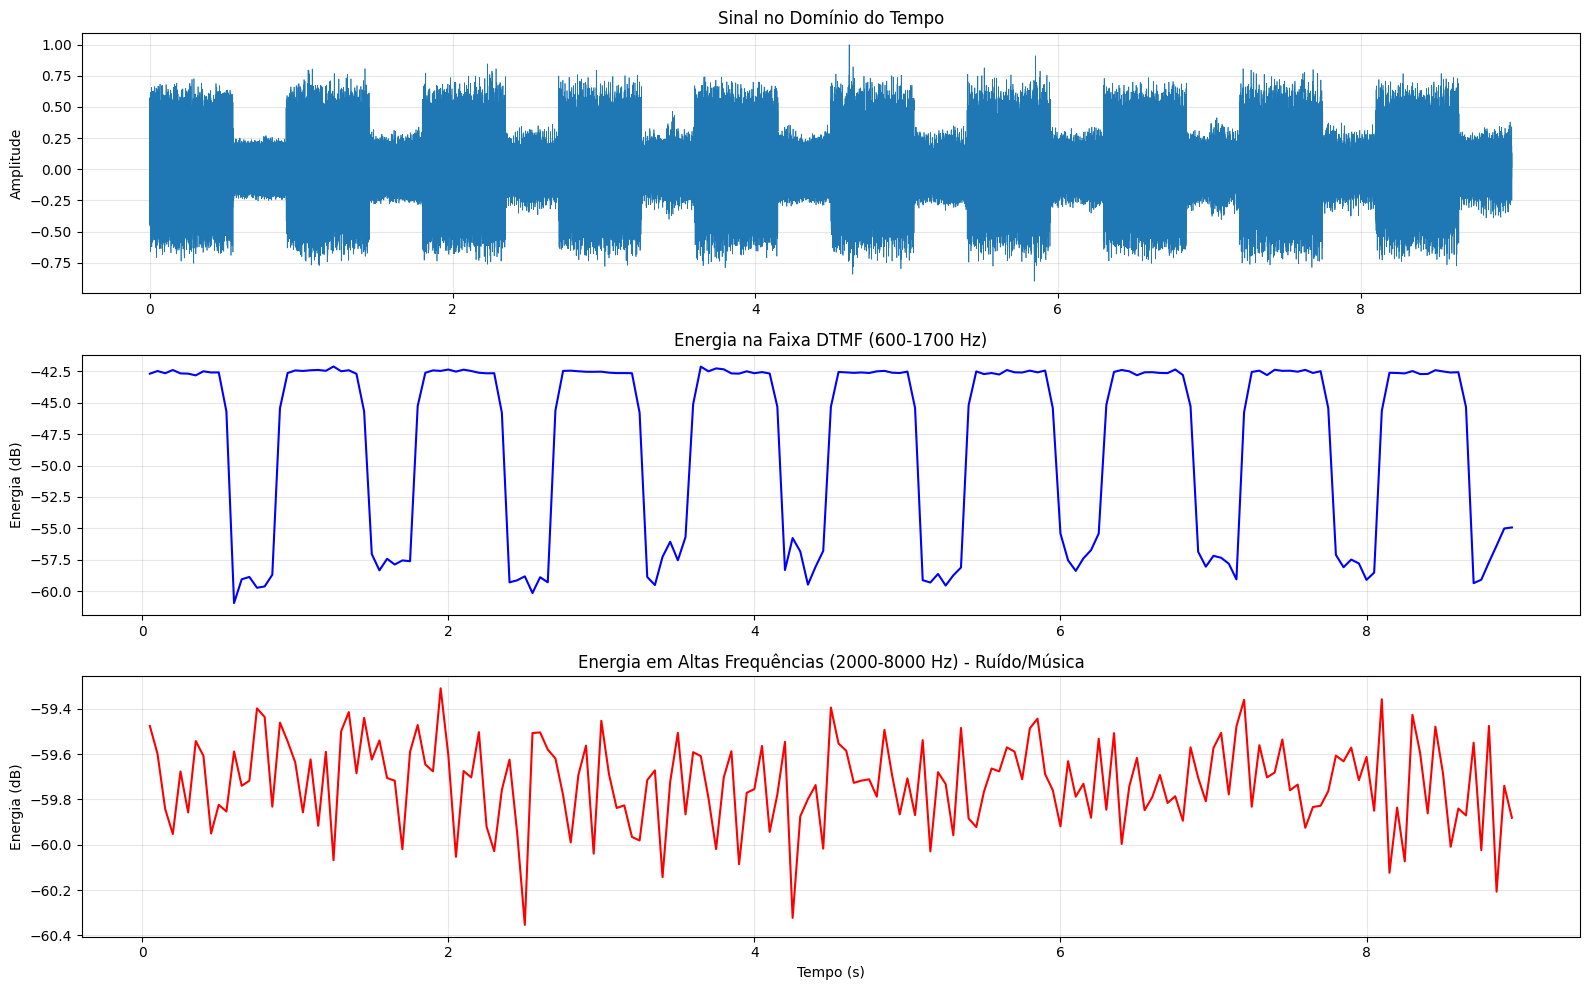

In [ ]:
# Calcular energia em diferentes faixas de frequência ao longo do tempo

# Faixa DTMF (600-1700 Hz)
idx_dtmf = np.where((f >= 600) & (f <= 1700))[0]
energia_dtmf = np.mean(10**(Sxx_dB[idx_dtmf, :]/10), axis=0)

# Faixa de música/ruído (2000-8000 Hz) - fora da faixa DTMF
idx_ruido = np.where((f >= 2000) & (f <= 8000))[0]
energia_ruido = np.mean(10**(Sxx_dB[idx_ruido, :]/10), axis=0)

# Plotar energias
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))

# Sinal no tempo
ax1.plot(tempo, sinal, linewidth=0.5)
ax1.set_ylabel('Amplitude')
ax1.set_title('Sinal no Domínio do Tempo')
ax1.grid(True, alpha=0.3)

# Energia DTMF
ax2.plot(t, 10*np.log10(energia_dtmf + 1e-12), 'b-', linewidth=1.5)
ax2.set_ylabel('Energia (dB)')
ax2.set_title('Energia na Faixa DTMF (600-1700 Hz)')
ax2.grid(True, alpha=0.3)

# Energia ruído
ax3.plot(t, 10*np.log10(energia_ruido + 1e-12), 'r-', linewidth=1.5)
ax3.set_ylabel('Energia (dB)')
ax3.set_xlabel('Tempo (s)')
ax3.set_title('Energia em Altas Frequências (2000-8000 Hz) - Ruído/Música')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




#Se pa que é demais

In [ ]:
# Detectar regiões de DTMF (picos de energia na faixa DTMF)
threshold_dtmf = np.percentile(energia_dtmf, 70)  # Threshold adaptativo
regioes_dtmf = energia_dtmf > threshold_dtmf

# Encontrar transições
transicoes = np.diff(regioes_dtmf.astype(int))
inicio_dtmf = np.where(transicoes == 1)[0]
fim_dtmf = np.where(transicoes == -1)[0]

print("\n=== REGIÕES IDENTIFICADAS ===")
print(f"\nNúmero de possíveis tons DTMF detectados: {len(inicio_dtmf)}")

if len(inicio_dtmf) > 0:
    print("\nRegiões de DTMF (aproximadas):")
    for i, (ini, fim) in enumerate(zip(inicio_dtmf, fim_dtmf[:len(inicio_dtmf)])):
        print(f"  Tom {i+1}: {t[ini]:.3f}s a {t[fim]:.3f}s (duração: {t[fim]-t[ini]:.3f}s)")



# Parede demais


=== REGIÕES IDENTIFICADAS ===

Número de possíveis tons DTMF detectados: 25

Regiões de DTMF (aproximadas):
  Tom 1: 0.050s a 0.100s (duração: 0.050s)
  Tom 2: 0.150s a 0.200s (duração: 0.050s)
  Tom 3: 0.350s a 0.400s (duração: 0.050s)
  Tom 4: 0.950s a 1.350s (duração: 0.400s)
  Tom 5: 1.850s a 2.150s (duração: 0.300s)
  Tom 6: 2.700s a 3.000s (duração: 0.300s)
  Tom 7: 3.600s a 3.800s (duração: 0.200s)
  Tom 8: 3.900s a 3.950s (duração: 0.050s)
  Tom 9: 4.000s a 4.050s (duração: 0.050s)
  Tom 10: 4.500s a 4.550s (duração: 0.050s)
  Tom 11: 4.750s a 4.850s (duração: 0.100s)
  Tom 12: 4.950s a 5.000s (duração: 0.050s)
  Tom 13: 5.400s a 5.450s (duração: 0.050s)
  Tom 14: 5.600s a 5.650s (duração: 0.050s)
  Tom 15: 5.750s a 5.800s (duração: 0.050s)
  Tom 16: 5.850s a 5.900s (duração: 0.050s)
  Tom 17: 6.300s a 6.450s (duração: 0.150s)
  Tom 18: 6.550s a 6.600s (duração: 0.050s)
  Tom 19: 6.700s a 6.750s (duração: 0.050s)
  Tom 20: 7.200s a 7.300s (duração: 0.100s)
  Tom 21: 7.350s a 7

## 5. Análise Espectral Média por Região

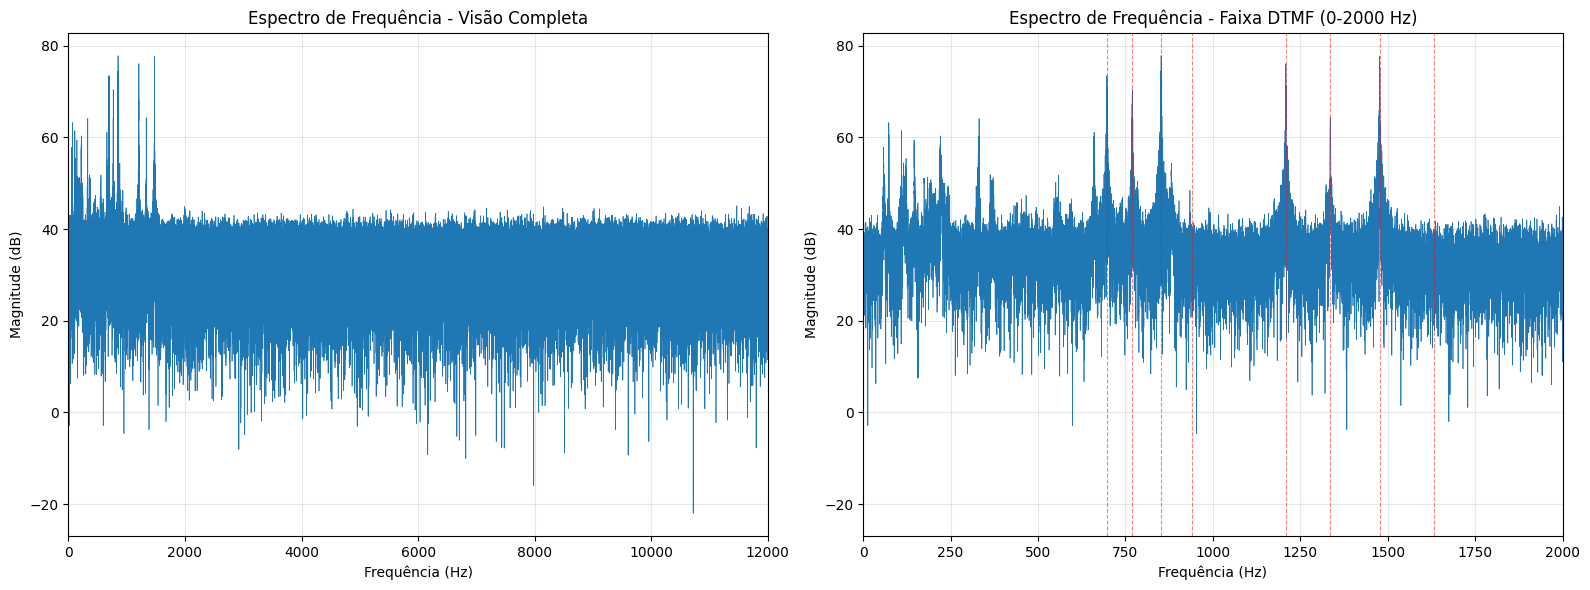

In [15]:
# Calcular espectro médio de diferentes regiões
from scipy.fft import fft, fftfreq

# FFT do sinal completo
N = len(sinal)
fft_sinal = fft(sinal)
freq_fft = fftfreq(N, 1/fs)

# Pegar apenas frequências positivas
idx_pos = freq_fft > 0
freq_fft_pos = freq_fft[idx_pos]
fft_magnitude = np.abs(fft_sinal[idx_pos])
fft_magnitude_db = 20 * np.log10(fft_magnitude + 1e-12)

# Plotar
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(freq_fft_pos, fft_magnitude_db, linewidth=0.5)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro de Frequência - Visão Completa')
plt.xlim([0, fs/2])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(freq_fft_pos, fft_magnitude_db, linewidth=0.5)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro de Frequência - Faixa DTMF (0-2000 Hz)')
plt.xlim([0, 2000])

# Marcar frequências DTMF
for freq in freq_dtmf_baixas + freq_dtmf_altas:
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.5, linewidth=0.8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Conclusões da Análise Inicial

### Identificação das Regiões:

1. **Regiões de DTMF**: Identificadas por picos de energia concentrados nas frequências características (697-1633 Hz)
2. **Regiões de Ruído (9ª Sinfonia)**: Presença de energia distribuída em ampla faixa de frequências, especialmente acima de 2 kHz
3. **Tecla 7 incorreta**: Necessita ser identificada e removida

### Próximos Passos:
- Aplicar filtro anti-aliasing antes do downsampling
- Realizar downsampling do sinal
- Projetar filtros FIR para eliminar ruídos
- Identificar e remover dígito repetido
- Decodificar sequência DTMF

In [16]:
# Salvar dados para próximos notebooks
np.savez('dados_analise_inicial.npz', 
         sinal=sinal, 
         fs=fs, 
         tempo=tempo,
         freq_dtmf_baixas=freq_dtmf_baixas,
         freq_dtmf_altas=freq_dtmf_altas)

print("\nDados salvos em 'dados_analise_inicial.npz'")
print("Continue para o próximo notebook: 02_downsampling_antialiasing.ipynb")


Dados salvos em 'dados_analise_inicial.npz'
Continue para o próximo notebook: 02_downsampling_antialiasing.ipynb


In [ ]:
# Faltou:

# separar rregiões de sinal dmtf, regiões de ruido e região da nona sinfonaia